# Unit 1 Capstone Narative Analytics and Experimentation
By: Katie Peterson

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from datetime import datetime

## Data Set Analysis
__Source:__ [https://www.kaggle.com/sohier/crime-in-baltimore]

__Context:__ This data set comes from the Baltimore Police Department and represents victim based crime data.  This data is important to analyze to understand the city crime patterns and to implement efforts to stop crimes from happening in the first place. My initial analysis will analyze data for the entire city from 2012 to 2017.  I will identify patterns in order to zoom in on actions that could potentially impact the data.


In [2]:
#import data
bpd = pd.read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv', dtype={'Premise':str})
bpd.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents
0,09/02/2017,23:30:00,3JK,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,913.0,SOUTHERN,Brooklyn,-76.60541,39.22951,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1
1,09/02/2017,23:00:00,7A,800 NEWINGTON AVE,AUTO THEFT,O,NaN,133.0,CENTRAL,Reservoir Hill,-76.63217,39.31360,"(39.3136000000, -76.6321700000)",STREET,1
2,09/02/2017,22:53:00,9S,600 RADNOR AV,SHOOTING,Outside,FIREARM,524.0,NORTHERN,Winston-Govans,-76.60697,39.34768,"(39.3476800000, -76.6069700000)",Street,1
3,09/02/2017,22:50:00,4C,1800 RAMSAY ST,AGG. ASSAULT,I,OTHER,934.0,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,"(39.2831500000, -76.6452600000)",ROW/TOWNHO,1
4,09/02/2017,22:31:00,4E,100 LIGHT ST,COMMON ASSAULT,O,HANDS,113.0,CENTRAL,Downtown West,-76.61365,39.28756,"(39.2875600000, -76.6136500000)",STREET,1


In [3]:
#identify where entries are null
bpd.isnull().sum()

CrimeDate               0
CrimeTime               0
CrimeCode               0
Location             2207
Description             0
Inside/Outside      10279
Weapon             180952
Post                  224
District               80
Neighborhood         2740
Longitude            2204
Latitude             2204
Location 1           2204
Premise             10757
Total Incidents         0
dtype: int64

It appears that the date, time, crime code, and crime descriptions are required for all entries.  Additionally, all entries in the Total Incidents column are equal to 1. Some of the columns need to be cleaned up for analysis, for example Inside/Outside, and Premise. 

In [5]:
#change Inside/Outside column name for ease of use
bpd.columns = ['CrimeDate', 'CrimeTime', 'CrimeCode', 'Location', 'Description',
       'InsideOutside', 'Weapon', 'Post', 'District', 'Neighborhood',
       'Longitude', 'Latitude', 'Location 1', 'Premise', 'Total Incidents']

In [6]:
#describing locations of crimes
bpd['InsideOutside'].value_counts()

I          131999
O          129782
Outside      3837
Inside        632
Name: InsideOutside, dtype: int64

In [7]:
#combining labels of I with inside and O with outside
inside = bpd.InsideOutside.replace('Inside', 'I')
outside = inside.replace('Outside', 'O')
bpd['InsideOutside'] = outside
bpd['InsideOutside'].value_counts()

O    133619
I    132631
Name: InsideOutside, dtype: int64

In [8]:
#cleaning up premise by stripping and upper cases
p_strip = bpd['Premise'].map(lambda x: x.strip() if type(x) is str else x)
p_upper = p_strip.map(lambda x: x.upper() if type(x) is str else x)
bpd['Premise'] = p_upper
bpd.Premise.value_counts().head()


STREET        103802
ROW/TOWNHO     60502
PARKING LO     12176
APT/CONDO      12002
OTHER - IN     11459
Name: Premise, dtype: int64

To facilitate analysis by year, month, and hour of day, I will break the CrimeDate and CrimeTime columns down into their respective parts.

In [9]:
#slicing for year, month and hour
bpd['year'] = bpd.CrimeDate.map(lambda x: x[6:])
bpd['month'] = bpd.CrimeDate.map(lambda x: x[:2])
bpd['hour'] = bpd.CrimeTime.map(lambda x: x[:2])
bpd.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,InsideOutside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents,year,month,hour
0,09/02/2017,23:30:00,3JK,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,913.0,SOUTHERN,Brooklyn,-76.60541,39.22951,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1,2017,09,23
1,09/02/2017,23:00:00,7A,800 NEWINGTON AVE,AUTO THEFT,O,NaN,133.0,CENTRAL,Reservoir Hill,-76.63217,39.31360,"(39.3136000000, -76.6321700000)",STREET,1,2017,09,23
2,09/02/2017,22:53:00,9S,600 RADNOR AV,SHOOTING,O,FIREARM,524.0,NORTHERN,Winston-Govans,-76.60697,39.34768,"(39.3476800000, -76.6069700000)",STREET,1,2017,09,22
3,09/02/2017,22:50:00,4C,1800 RAMSAY ST,AGG. ASSAULT,I,OTHER,934.0,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,"(39.2831500000, -76.6452600000)",ROW/TOWNHO,1,2017,09,22
4,09/02/2017,22:31:00,4E,100 LIGHT ST,COMMON ASSAULT,O,HANDS,113.0,CENTRAL,Downtown West,-76.61365,39.28756,"(39.2875600000, -76.6136500000)",STREET,1,2017,09,22


The premise that has the highest occurrence of crimes (approximately double the second highest) is the street.  To further investigate this, I broke down the data frame into just street crimes and found the most common type of crime in the streets and which neighborhood has the highest occurrence of street crimes.

In [10]:
#creating data frame for only street crimes
street_crime = bpd[bpd.Premise == 'STREET']
street_crime = street_crime.reset_index(drop=True)
#street crimes broken down by type of crime
street_crime.Description.value_counts()

LARCENY FROM AUTO       25817
AUTO THEFT              19335
LARCENY                 15246
ROBBERY - STREET        13027
COMMON ASSAULT          13017
AGG. ASSAULT            11504
SHOOTING                 2049
ROBBERY - CARJACKING     1140
HOMICIDE                  834
ASSAULT BY THREAT         601
ARSON                     467
BURGLARY                  336
ROBBERY - COMMERCIAL      207
RAPE                      187
ROBBERY - RESIDENCE        35
Name: Description, dtype: int64

In [41]:
#street crimes broken down by district
street_crime.District.value_counts()

SOUTHEASTERN    15988
NORTHEASTERN    14000
CENTRAL         13285
SOUTHERN        11497
NORTHERN        10579
EASTERN          9763
NORTHWESTERN     9667
WESTERN          9649
SOUTHWESTERN     9344
Name: District, dtype: int64

In [11]:
#street crimes broken down by neighborhood
street_crime.Neighborhood.value_counts().head(10)

Downtown                     3809
Belair-Edison                1964
Sandtown-Winchester          1823
Frankford                    1697
Canton                       1666
Fells Point                  1643
Brooklyn                     1601
Patterson Park Neighborho    1601
Washington Village/Pigtow    1281
Upton                        1263
Name: Neighborhood, dtype: int64

In [12]:
#identify pattern of street crimes over the past years
street_crime_year = street_crime.year.value_counts().sort_index(axis=0, ascending=True)
print(street_crime_year)

2012    17381
2013    17964
2014    17458
2015    20191
2016    19906
2017    10902
Name: year, dtype: int64


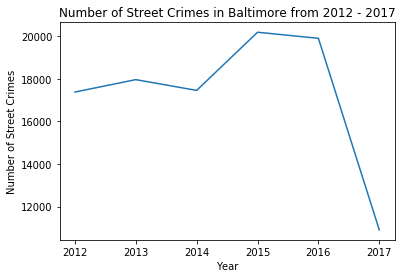

In [13]:
#plotting street crimes by year
plt.plot(street_crime_year.index, street_crime_year)
plt.xlabel('Year')
plt.ylabel('Number of Street Crimes')
plt.title('Number of Street Crimes in Baltimore from 2012 - 2017')
plt.show()

While it appears that there is a large decrease in street crime in 2017, this data set only contains data for Jan 1, 2017 through September 3, 2017.  Given that, the data indicates that 2015 and 2016 had a higher number of crimes than in the previous three years.  To identify if current trends are similar to those of 2015 and 2016, I will analyze that data specifically.

In [17]:
#creating data frame for street crimes in 2017
bpd2017_street = street_crime[street_crime['year'] == '2017']
#counting street crimes by month  
bpd2017_s_month = bpd2017_street.month.value_counts().sort_index(axis=0, ascending=True)

In [18]:
#creating data frame for street crimes in 2016
bpd2016_street = street_crime[street_crime['year'] == '2016']
#counting street crimes by month  
bpd2016_s_month = bpd2016_street.month.value_counts().sort_index(axis=0, ascending=True)

In [25]:
#creating data frame for street crimes in 2015
bpd2015_street = street_crime[street_crime['year'] == '2015']
#counting street crimes by month  
bpd2015_s_month = bpd2015_street.month.value_counts().sort_index(axis=0, ascending=True)

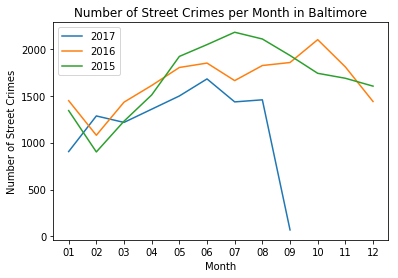

In [26]:
plt.plot(bpd2017_s_month.index, bpd2017_s_month, label='2017')
plt.plot(bpd2016_s_month.index, bpd2016_s_month, label='2016')
plt.plot(bpd2015_s_month.index, bpd2015_s_month, label='2015')
plt.xlabel('Month')
plt.ylabel('Number of Street Crimes')
plt.title('Number of Street Crimes per Month in Baltimore')
plt.legend()
plt.show()

Note that April through July of 2015 were the protests and riots following Freddie Gray's death.  This explains the spike in crimes in those months of 2015.

#### Type and Time of Crime
According to the data, 2016 and 2017 are following similar trends to one another, therefore in order to identify current trends, I will focus my analysis on 2017 crimes.  In particular, I want to know which type of street crimes are most common, and when they occur.

In [28]:
#identifing top types of street crimes 
bpd2017_street.Description.value_counts()

LARCENY FROM AUTO       2048
AUTO THEFT              1854
LARCENY                 1643
ROBBERY - STREET        1538
AGG. ASSAULT            1452
COMMON ASSAULT          1314
SHOOTING                 370
ROBBERY - CARJACKING     237
HOMICIDE                 167
BURGLARY                  89
ASSAULT BY THREAT         70
ARSON                     49
ROBBERY - COMMERCIAL      43
RAPE                      16
ROBBERY - RESIDENCE       12
Name: Description, dtype: int64

In [30]:
#pulling data frames for the six top types of street crimes
sc2017_lar = bpd2017_street[bpd2017_street['Description'] == 'LARCENY']
#counting occurrences of crime by hour
sc2017_lar_hour = sc2017_lar.hour.value_counts().sort_index(axis=0, ascending=True)

sc2017_lfa = bpd2017_street[bpd2017_street['Description'] == 'LARCENY FROM AUTO']
sc2017_lfa_hour = sc2017_lfa.hour.value_counts().sort_index(axis=0, ascending=True)

sc2017_at = bpd2017_street[bpd2017_street['Description'] == 'AUTO THEFT']
sc2017_at_hour = sc2017_at.hour.value_counts().sort_index(axis=0, ascending=True)

sc2017_rs = bpd2017_street[bpd2017_street['Description'] == 'ROBBERY - STREET']
sc2017_rs_hour = sc2017_rs.hour.value_counts().sort_index(axis=0, ascending=True)

sc2017_agg = bpd2017_street[bpd2017_street['Description'] == 'AGG. ASSAULT']
sc2017_agg_hour = sc2017_agg.hour.value_counts().sort_index(axis=0, ascending=True)

sc2017_ca = bpd2017_street[bpd2017_street['Description'] == 'COMMON ASSAULT']
sc2017_ca_hour = sc2017_ca.hour.value_counts().sort_index(axis=0, ascending=True)

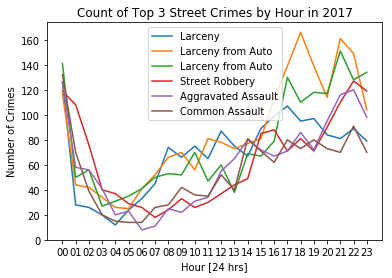

In [31]:
#plotting top six street crimes by hour
plt.plot(sc2017_lar_hour.index, sc2017_lar_hour, label='Larceny')
plt.plot(sc2017_lfa_hour.index, sc2017_lfa_hour, label='Larceny from Auto')
plt.plot(sc2017_at_hour.index, sc2017_at_hour, label='Auto Theft')
plt.plot(sc2017_rs_hour.index, sc2017_rs_hour, label='Street Robbery')
plt.plot(sc2017_agg_hour.index, sc2017_agg_hour, label='Aggravated Assault')
plt.plot(sc2017_ca_hour.index, sc2017_ca_hour, label='Common Assault')
plt.xlabel('Hour [24 hrs]')
plt.ylabel('Number of Crimes')
plt.title('Count of Top 6 Street Crimes by Hour in 2017')
plt.legend()
plt.show()

According to the data, most street crime occurs between 16:00 (4 pm) and 00:00 (midnight), with spikes at 6 pm, 10 pm, and midnight.

#### Districts
I wanted to see which districts had the highest street crimes to narrow down locations for possible crime prevention strategies.

In [40]:
#all 2017 crimes broken down by district
bpd2017_street.District.value_counts().head()

SOUTHEASTERN    1525
NORTHEASTERN    1505
SOUTHERN        1287
CENTRAL         1241
EASTERN         1179
Name: District, dtype: int64

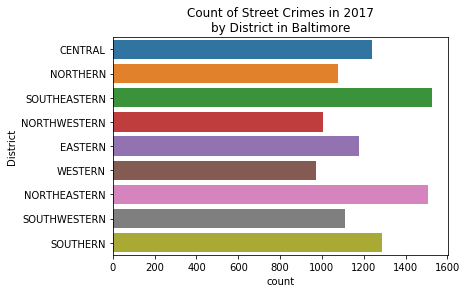

In [56]:
#plotting street crimes by district
g = sns.countplot(y='District', data=bpd2017_street)
plt.title('Count of Street Crimes in 2017\nby District in Baltimore')
plt.show()

The most street crimes occur in the Southeastern and Northeastern districts.  These would be the best areas to focus on for crime prevention.

#### Analysis Highlights
The majority of crimes in Baltimore occur on the streets, which are mostly larceny from auto, larceny, and auto theft.  These occurred primariliy between 4 pm and midnight and in the Southeastern and Northeastern districts.

### Experimental Hypothesis
If larceny from auto prevention strategies are employed in district, then street crime in that district will decrease. 

## A/B Test
The two versions of this test will be the Southeastern and Northeastern districts.  Both districts have similar numbers of street crimes occurring in each district, and based on this data, are very similar districts.  The Southeastern district will be our "test region", and the Northeastern district will be our "control region".  In the test region, we will employ auto theft prevention strategies, such as billboards and electronic signs with theft prevention tips.  The control region will continue to exist as normal.  The key metric used to assess this hypothesis will be the instances of street crime, specifically a t-test of the counts of street crime numbers in the districts.  We might also detect a change in the number of non-street crimes in that district as a result of the change.

## Rollout Plan
__Copy of Billboards/Electronic Signs:__ We will create billboards and signs in conjunction with auto theft prevention programs in place.  We will also determine how far apart to put the signs (1 sign per mile on main roads).

For example: [https://pbs.twimg.com/media/DK1XKS0VoAAWTe6.jpg]

[http://i.imgur.com/9DIOyhC.jpg] 

[http://www.ocalapost.com/wp-content/uploads/2015/10/burglaries.jpg]

__Rollout Plan:__ We will first target the Canton neighborhood as it is the neighborhood with the highest occurrence of street crimes in the Southeastern District. This will limit the financial strain of the billboards and signs at first before increasing the amount of signs required for the entire district.  We will monitor crime for one month in this neighborhood before assessing the initiative's efficacy and rolling out to the whole district.

Before rolling this out, we will investigate events happening in both districts to ensure that there is not one large event in one that would impact the crime in that district positively or negatively.  We will also test our electronic signs to ensure the quality of message that will be shown.  

__Success Metric:__ T-test for significance of changes between street crimes per month for the test and control districts.  The desired degree of significance is a p-value of less than 0.05.

## Evaluation Plan
If, during the first month of the test in Canton, there is a decrease in street crime by 10%, then roll out signs to the rest of the Southeastern district.  If street crimes decrease significantly in comparison to the Northeastern district (p-value less than 0.05), then implement the campaign across the city.  If street crimes decrease by 10%, but not significantly, observe for two more months before deciding.  If the campaign does not decrease in two months, remove signs.